I update this document also refere to 
1. https://www.tensorflow.org/tutorials/text/transformer?hl=zh-cn
2. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

# Transformer Network

Welcome to Week 4's assignment, the last assignment of Course 5 of the Deep Learning Specialization! And congratulations on making it to the last assignment of the entire Deep Learning Specialization - you're almost done!

Ealier in the course, you've implemented sequential neural networks such as RNNs, GRUs, and LSTMs. In this notebook you'll explore the Transformer architecture, a neural network that takes advantage of parallel processing and allows you to substantially speed up the training process. 

**After this assignment you'll be able to**:

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

For the last time, let's get started!

## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Sine and Cosine Angles](#1-1)
        - [Exercise 1 - get_angles](#ex-1)
    - [1.2 - Sine and Cosine Positional Encodings](#1-2)
        - [Exercise 2 - positional_encoding](#ex-2)
- [2 - Masking](#2)
    - [2.1 - Padding Mask](#2-1)
    - [2.2 - Look-ahead Mask](#2-2)
- [3 - Self-Attention](#3)
    - [Exercise 3 - scaled_dot_product_attention](#ex-3)
- [4 - Encoder](#4)
    - [4.1 Encoder Layer](#4-1)
        - [Exercise 4 - EncoderLayer](#ex-4)
    - [4.2 - Full Encoder](#4-2)
        - [Exercise 5 - Encoder](#ex-5)
- [5 - Decoder](#5)
    - [5.1 - Decoder Layer](#5-1)
        - [Exercise 6 - DecoderLayer](#ex-6)
    - [5.2 - Full Decoder](#5-2)
        - [Exercise 7 - Decoder](#ex-7)
- [6 - Transformer](#6)
    - [Exercise 8 - Transformer](#ex-8)
- [7 - References](#7)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [ ]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

import seaborn
seaborn.set_context(context="talk")

<a name='1'></a>
## 1 - Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:

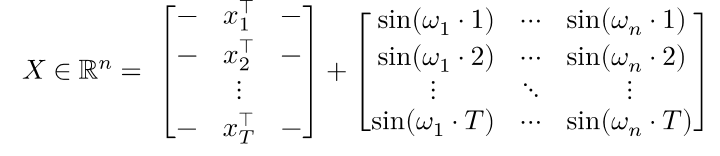
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
\tag{1}$$


$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
\tag{2}$$

<font size =5 color =red >**it is like FFT, I should check it later!!**</font>
* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.

The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. Note that while in the lectures Andrew uses vertical vectors but in this assignment, all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

<a name='1-1'></a>
### 1.1 - Sine and Cosine Angles

Get the possible angles used to compute the positional encodings by calculating the inner term of the sine and cosine equations: 

$$\frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

<a name='ex-1'></a>
### Exercise 1 - get_angles

Implement the function `get_angles()` to calculate the possible angles for the sine and cosine  positional encodings

In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION get_angles
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    # START CODE HERE
    angles = pos/ (np.power(10000, (2 * (i//2)) / np.float32(d)))
    # END CODE HERE
    
    return angles

In [5]:
# UNIT TEST
def get_angles_test(target):
    position = 4
    d_model = 16
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    result = target(pos_m, dims, d_model)

    assert type(result) == np.ndarray, "You must return a numpy ndarray"
    assert result.shape == (position, d_model), f"Wrong shape. We expected: ({position}, {d_model})"
    assert np.sum(result[0, :]) == 0
    assert np.isclose(np.sum(result[:, 0]), position * (position - 1) / 2)
    even_cols =  result[:, 0::2]
    odd_cols = result[:,  1::2]
    assert np.all(even_cols == odd_cols), "Submatrices of odd and even columns must be equal"
    # edge value of the angle (d_model =16)
    limit = (position - 1) / np.power(10000,14.0/16.0)
    assert np.isclose(result[position - 1, d_model -1], limit ), f"Last value must be {limit}"

    print("\033[92mAll tests passed")

get_angles_test(get_angles)

# Example
position = 4
d_model = 8
# add new dimension to column so it will be (4, 1)
pos_m = np.arange(position)[:, np.newaxis]
# add new dimension to row so it will be (1, 4)
dims = np.arange(d_model)[np.newaxis, :]
angles= get_angles(pos_m, dims, d_model)

All tests passed


In [6]:
pos_m

array([[0],
       [1],
       [2],
       [3]])

In [7]:
dims

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [8]:
angles

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

<a name='1-2'></a>
### 1.2 - Sine and Cosine Positional Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings.

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

<a name='ex-2'></a>
### Exercise 2 - positional_encoding

Implement the function `positional_encoding()` to calculate the sine and cosine  positional encodings

**Reminder:** Use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

#### Additional Hints
* You may find 
[np.newaxis](https://numpy.org/doc/stable/reference/arrays.indexing.html) useful depending on the implementation you choose. 

In [9]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION positional_encoding
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis,:],
                            d)
  
    # -> angle_rads has dim (positions,d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


In [10]:
# UNIT TEST
def positional_encoding_test(target):
    position = 8
    d_model = 16

    pos_encoding = target(position, d_model)
    sin_part = pos_encoding[:, :, 0::2]
    cos_part = pos_encoding[:, :, 1::2]

    assert tf.is_tensor(pos_encoding), "Output is not a tensor"
    assert pos_encoding.shape == (1, position, d_model), f"Wrong shape. We expected: (1, {position}, {d_model})"

    ones = sin_part ** 2  +  cos_part ** 2
    assert np.allclose(ones, np.ones((1, position, d_model // 2))), "Sum of square pairs must be 1 = sin(a)**2 + cos(a)**2"
    
    angs = np.arctan(sin_part / cos_part)
    angs[angs < 0] += np.pi
    angs[sin_part.numpy() < 0] += np.pi
    angs = angs % (2 * np.pi)
    
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    trueAngs = get_angles(pos_m, dims, d_model)[:, 0::2] % (2 * np.pi)
    
    assert np.allclose(angs[0], trueAngs), "Did you apply sin and cos to even and odd parts respectively?"
 
    print("\033[92mAll tests passed")
    
    
positional_encoding_test(positional_encoding)


All tests passed


2023-05-09 10:37:45.354620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 10:37:45.355316: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


another example implementation in torch https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

Nice work calculating the positional encodings! Now you can visualize them.

(1, 50, 512)


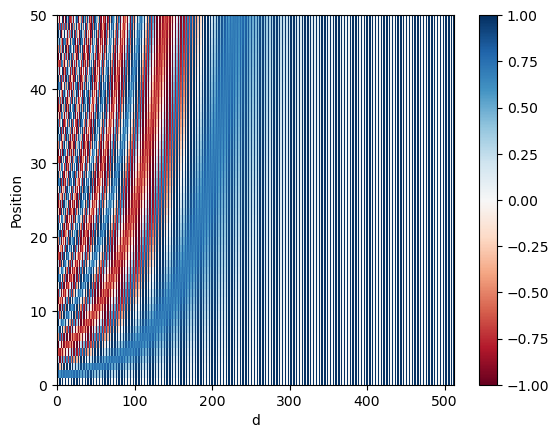

In [12]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

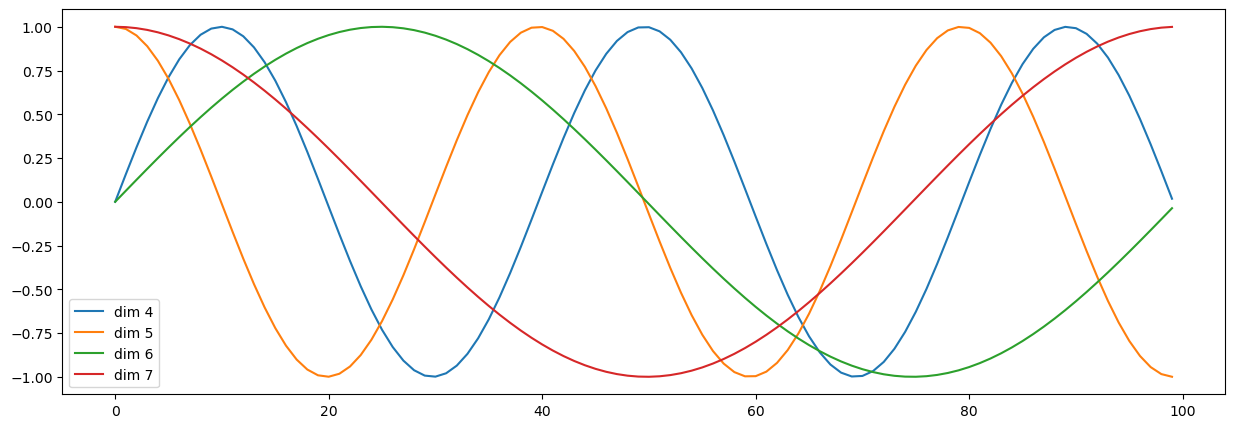

In [13]:
#forward acctually just adding the pos_endcoding to x, and adding one dropout which is ingored here
#this is just for corss check the pos_endcoding 
def forward(x , pos_encoding):
    x = x + tf.Variable(pos_encoding[:, :x.shape[1]])
    return x

plt.figure(figsize=(15, 5))
position = 100
d_model = 20
pos_encoding = positional_encoding(position, d_model)
y = forward(tf.Variable(tf.zeros([1, 100, 20])),pos_encoding)
tf.Variable(tf.zeros([1, 100, 20]))
#you will see the different value added
plt.plot(np.arange(100), y[0, :, 4:8])
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

Each row represents a positional encoding - <font size=5 color=red>notice how none of the rows are identical! </font> You have created a unique positional encoding for each of the words.

<a name='2'></a>
## 2 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

<a name='2-1'></a>
### 2.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
<font color=red>Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length.</font> Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by -1e9 and adding it to your sequence, you mask out the zeros by setting them to close to negative infinity. We'll implement this for you so you can get to the fun of building the Transformer network! 😇 Just make sure you go through the code so you can correctly implement padding when building your model. 

After masking, your input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when you take the softmax, the zeros don't affect the score.

In [14]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :] 

In [15]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


If we multiply this mask by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. Notice the difference when taking the softmax of the original sequence and the masked sequence:

In [16]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809818e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952457e-01 6.2391245e-01 3.1062772e-02 3.1062772e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088354e-03]
   [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00
    9.0030573e-02]
   [6.6483542e-03 6.6483542e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057157e-01 2.6876226e-01 6.6619506e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030566e-02 2.4472845e-01 6.6524088e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]]]], shape

<a name='2-2'></a>
### 2.2 - Look-ahead Mask -- it looks like the mask M in "imported/implementing-transformers.ipynb"  -- no, it is not same, the M is used in softmax 

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output. 

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

Just because you've worked so hard, we'll also implement this mask for you 😇😇. Again, take a close look at the code so you can effictively implement it later.

In [17]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

In [18]:
x = tf.random.uniform((1, 3))
print(x)
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor([[0.8312781  0.24044645 0.17191601]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

<a name='3'></a>
## 3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<center><img src="./assets/self-attention.png" alt="Encoder" width="600"/></center>
<caption><center><font color='purple'>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

<a name='ex-3'></a>
### Exercise 3 - scaled_dot_product_attention 

    Implement the function `scaled_dot_product_attention()` to create attention-based representations
**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. Multiply it by -1e9 before applying the softmax. 

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.

Q，K和V是经过卷积后得到的特征，其形状为（batch_size，seq_length，num_features）。

将查询（Q）和键（K）相乘会得到（batch_size，seq_length，seq_length）特征，这大致告诉我们序列中每个元素的重要性，确定我们“注意”哪些元素。 注意数组使用softmax标准化，因此所有权重之和为1。 最后，注意力将通过矩阵乘法应用于值（V）数组。
请注意，MatMul操作在PyTorch中对应为torch.bmm。 这是因为Q，K和V（查询，键和值数组）都是矩阵，每个矩阵的形状均为（batch_size，sequence_length，num_features），矩阵乘法仅在最后两个维度上执行。

In [19]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    # START CODE HERE
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)
    
    # END CODE HERE

    return output, attention_weights

In [20]:
# UNIT TEST
def scaled_dot_product_attention_test(target):
    q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)  #accoridng to vector is horizontal, so here means q is 4 feature vector but 
                                                                                 #3 is the seq_len， so here 3x4 matrix
    k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32) #k shape (4,4), still 4 is the seq_len but lenth is also 4
                                                                                               #q , v should have the same feature number , but it could be different 
                                                                                               #lenght?? -- it seems not reasonable ?
    v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)    #q lenth is  should be 4, feature bumber is 2

    attention, weights = target(q, k, v, None)
    assert tf.is_tensor(weights), "Weights must be a tensor"
    #so here the weight shape is 3x4, shape should be (q.shape[0], k.shape[0]) instead of  (q.shape[0], k.shape[1]), k is transpose
    #assert tuple(tf.shape(weights).numpy()) == (q.shape[0], k.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[1]})"
    assert tuple(tf.shape(weights).numpy()) == (q.shape[0], k.shape[0]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[0]})"
    
    assert np.allclose(weights, [[0.2589478,  0.42693272, 0.15705977, 0.15705977],
                                   [0.2772748,  0.2772748,  0.2772748,  0.16817567],
                                   [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

    assert tf.is_tensor(attention), "Output must be a tensor"
    assert tuple(tf.shape(attention).numpy()) == (q.shape[0], v.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {v.shape[1]})"
    assert np.allclose(attention, [[0.74105227, 0.15705977],
                                   [0.7227253,  0.16817567],
                                   [0.6637989,  0.2039163 ]])

    mask = np.array([[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0]])
    attention, weights = target(q, k, v, mask)

    assert np.allclose(weights, [[0.30719590187072754, 0.5064803957939148, 0.0, 0.18632373213768005],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862]]), "Wrong masked weights"
    assert np.allclose(attention, [[0.6928040981292725, 0.18632373213768005],
                                   [0.6163482666015625, 0.2326965481042862], 
                                   [0.6163482666015625, 0.2326965481042862]]), "Wrong masked attention"
    
    print("\033[92mAll tests passed")
    return attention, weights 
    
attention, weights = scaled_dot_product_attention_test(scaled_dot_product_attention)
print(attention)
print(weights)

All tests passed
tf.Tensor(
[[0.6928041  0.18632373]
 [0.61634827 0.23269655]
 [0.61634827 0.23269655]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.3071959  0.5064804  0.         0.18632373]
 [0.38365173 0.38365173 0.         0.23269655]
 [0.38365173 0.38365173 0.         0.23269655]], shape=(3, 4), dtype=float32)


In [21]:
q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)
print(k.shape)
matmul_qk = tf.matmul(q, k, transpose_b=True)
print(matmul_qk)

(4, 4)
tf.Tensor(
[[2. 3. 1. 1.]
 [2. 2. 2. 1.]
 [2. 2. 0. 1.]], shape=(3, 4), dtype=float32)


another sample to Obtaining Query, Key and Value matrix

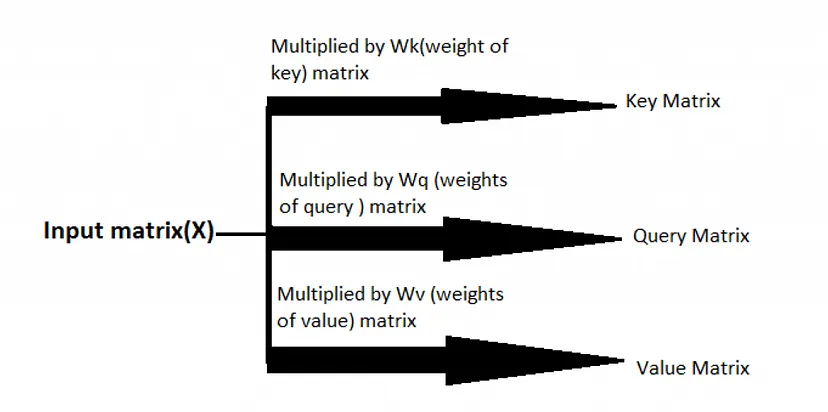!

In [22]:
#generate the emdedding the word vector for "this is book", each vector have 5 features
print(f"Shape is :- {np.random.randn(3,5).shape}")
X=np.random.randn(3,5)
X

Shape is :- (3, 5)


array([[ 0.47858264, -1.74327212, -0.82029071, -0.21163698,  1.31543753],
       [-0.09012238, -0.48729982,  0.84112528,  1.85078928,  0.32633046],
       [-1.62962921,  0.17127885, -0.49912593,  0.09966805, -0.55323133]])

In [23]:
weight_of_query=np.random.randn(5,3)
weight_of_query
Query=np.matmul(X,weight_of_query)
Query

array([[-2.28215318, -0.37214572,  0.97116363],
       [-0.04802642,  1.48761478, -0.61758178],
       [-2.79664269, -3.07753598, -0.81546614]])

In [24]:
weight_of_key=np.random.randn(5,3)
weight_of_key
Key=np.matmul(X,weight_of_key)
Key

array([[-2.03322686,  1.9992987 ,  2.09889272],
       [ 0.1997882 ,  0.12002915, -3.34110812],
       [ 3.23284659, -0.30207486, -0.76657696]])

In [25]:
weight_of_values=np.random.randn(5,3)
weight_of_values
Values=np.matmul(X,weight_of_values)
Values

array([[-2.60174708, -1.75190164, -1.32735991],
       [-2.93463348,  0.28382245, -1.42966431],
       [ 1.57416533,  3.9202751 , -0.21375642]])

**so most cases the W_q, W_k, W_v are same shape, so the q, k, v also have the same shape**  
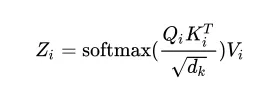

In [26]:
dimension=5
Scores=np.matmul(Query,Key.T)/np.sqrt(dimension) #score is the weights
Scores

array([[ 2.653977  , -1.6749841 , -3.58213928],
       [ 0.79407112,  0.998346  , -0.0586785 ],
       [-0.97415669,  0.80338804, -3.34799884]])

Excellent work! You can now implement self-attention. With that, you can start building the encoder block! 

<a name='4'></a>
## 4 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a).   
<center><img src="./assets/encoder_layer.png" alt="Encoder" width="250"/></center>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</b></font></center></caption>

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation. 
* You will also use the [Sequential API](https://keras.io/api/models/sequential/) with two dense layers to built the feed forward neural network layers.

In [27]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

In [59]:
sample_ffn = FullyConnected(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

<a name='4-1'></a>
### 4.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).

<a name='ex-4'></a>
### Exercise 4 - EncoderLayer

Implement `EncoderLayer()` using the `call()` method

In this exercise, you will implement one encoder block (Figure 2) using the `call()` method. The function should perform the following steps: 
1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K should be the same.
2. Next, you will pass the output of the multi-head attention layer to a dropout layer. Don't forget to use the `training` parameter to set the mode of your model. 
3. Now add a skip connection by adding your original input `x` and the output of the dropout layer. 
4. After adding the skip connection, pass the output through the first layer normalization.
5. Finally, repeat steps 1-4 but with the feed forward neural network instead of the multi-head attention layer.

**Additional Hints**:
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`. 
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. *Note that if query, key and value are the same, then this function performs self-attention.*

In [28]:
# I borrow the another implemenation of the MultiHeadAttention to cross check 
def multihead_attention(X, mask, heads, W_KQV, W_out):
    N,T,d = X.shape
    K,Q,V = np.split(X@W_KQV, 3, axis=-1)
    K,Q,V = [a.reshape(N,T,heads,d//heads).swapaxes(1,2) for a in (K,Q,V)]
    
    attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(d//heads) + mask)
    return (attn@V).swapaxes(1,2).reshape(N,T,d) @ W_out, attn

多头注意力由四部分组成：

线性层并分拆成多头。
按比缩放的点积注意力。
多头及联。
最后一层线性层。
每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。-- <font size=4 color=red>先经过dense 层,然后再分拆层多头matrix 喂给多个head ，经过学习后这些dense网络的W_q, W_k, W_v, 其实和前面实现中的W_q, W_k, W_v是相同的作用</font>

将上面定义的 scaled_dot_product_attention 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用tf.transpose 和 tf.reshape），并放入最后的 Dense 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

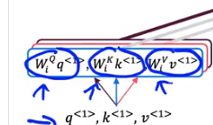

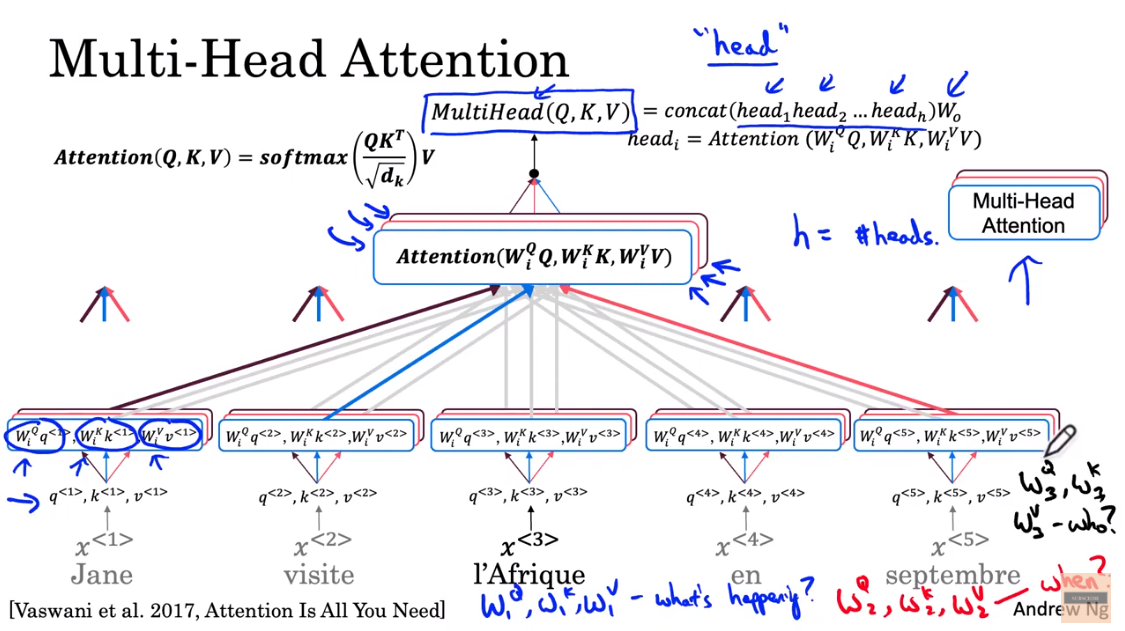
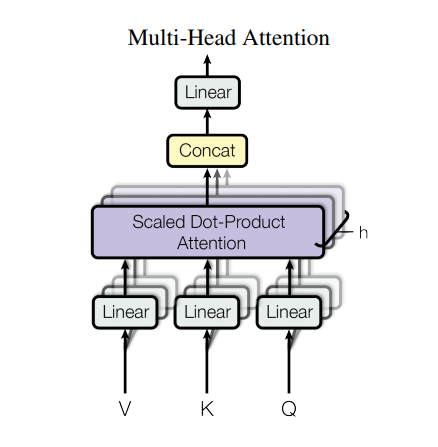

In [ ]:
# borrow the clip implemenation of the MultiHeadAttention to cross check 
class MultiheadAttention(nn.Module):
    def __init__(self, n_ctx, width, heads):
        super().__init__()
        self.n_ctx = n_ctx
        self.width = width
        self.heads = heads
        self.c_qkv = nn.Linear(width, width * 3)
        self.c_proj = nn.Linear(width, width)
        self.attention = QKVMultiheadAttention(heads, n_ctx)

    def forward(self, x):
        x = self.c_qkv(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x


class MLP(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.c_fc = nn.Linear(width, width * 4)
        self.c_proj = nn.Linear(width * 4, width)
        self.gelu = nn.GELU()

    def forward(self, x):
        return self.c_proj(self.gelu(self.c_fc(x)))


class QKVMultiheadAttention(nn.Module):
    def __init__(self, n_heads: int, n_ctx: int):
        super().__init__()
        self.n_heads = n_heads
        self.n_ctx = n_ctx

    def forward(self, qkv):
        #get bachsize , 
        bs, n_ctx, width = qkv.shape
        attn_ch = width // self.n_heads // 3
        scale = 1 / math.sqrt(math.sqrt(attn_ch))
        qkv = qkv.view(bs, n_ctx, self.n_heads, -1)
        
        ### 分拆最后q,k,v维度到 (num_heads, depth).
        q, k, v = th.split(qkv, attn_ch, dim=-1)
        weight = th.einsum(
            "bthc,bshc->bhts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        wdtype = weight.dtype

        ### calucate the softmax attention
        weight = th.softmax(weight.float(), dim=-1).type(wdtype)
        return th.einsum("bhts,bshc->bthc", weight, v).reshape(bs, n_ctx, -1)

In [70]:
# I borrow the another implemenation of the MultiHeadAttention to cross check 
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0

        ## numbers heads will collapse the feature depth into heads.. such as feed features parallel to different heads so that improve the efficiency
        self.depth = d_model // self.num_heads 
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, v, k, mask, return_attention_scores=False):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        #reverse the split head procedure 
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        if return_attention_scores:
            return output, attention_weights
        else:
            return output

In [74]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(q=y, v=y, k=y, mask=None,return_attention_scores=True)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [75]:
temp_mha.num_heads

8

In [76]:
## if for tf , give the number_heads > key_dim , how the output could be?
layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=4)
target = tf.keras.Input(shape=[8, 4])
source = tf.keras.Input(shape=[4, 4])
output_tensor, weights = layer(target, source,
                               return_attention_scores=True)
print(output_tensor.shape)

print(weights.shape)


(None, 8, 4)
(None, 8, 8, 4)


In [77]:
#check the matrix split heads
batch_size = tf.shape(y)[0]
depth = 512 // 8  # numbers heads will collapse the feature depth into heads.. such as feed features parallel to different heads so that improve the efficiency
num_heads = 8
wq = tf.keras.layers.Dense(512)
q = wq(y)
#check split heads
x = tf.reshape(q, (batch_size, -1, num_heads, depth)) # (batch_size, seq_len_q ,num_heads, depth)
x = tf.transpose(x, perm=[0, 2, 1, 3]) # (batch_size, num_heads, seq_len_q, depth)
x.shape

TensorShape([1, 8, 60, 64])

In [78]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()
        self.ownMultiHead = ownMultiHead
        
        if (ownMultiHead==False):
            self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=embedding_dim)
        else:
            self.mha = MultiHeadAttention(embedding_dim,num_heads)
        
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line)
        #-> To compute self-attention Q, V and K should be the same (x)
        #ztd, namely it should be different q, v and k, but it seems merged with  EmbeddingParamtersMatrix*(Embedding matrix *X)
        self_attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        self_attn_output = self.dropout1(self_attn_output, training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        mult_attn_out = self.layernorm1(x + self_attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE
        
        return encoder_layer_out

In [79]:
# UNIT TEST
ownMultiHead=True
def EncoderLayer_test(target):
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    encoder_layer1 = EncoderLayer(4, 2, 8)
    tf.random.set_seed(10)
    encoded = encoder_layer1(q, True, np.array([[1, 0, 1]]))
    
    assert tf.is_tensor(encoded), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoded).numpy()) == (1, q.shape[1], q.shape[2]), f"Wrong shape. We expected ((1, {q.shape[1]}, {q.shape[2]}))"
    print(encoded.numpy())
    assert np.allclose(encoded.numpy(), 
                       [[-0.5214877 , -1.001476  , -0.12321664,  1.6461804 ],
                       [-1.3114998 ,  1.2167752 , -0.5830886 ,  0.6778133 ],
                       [ 0.25485858,  0.3776546 , -1.6564771 ,  1.023964  ]],), "Wrong values"
    
    print("\033[92mAll tests passed")
    

EncoderLayer_test(EncoderLayer)

[[[-0.12410855 -1.4025799   0.1106668   1.4160216 ]
  [-1.4312509  -0.02727069  0.06325354  1.3952682 ]
  [-0.0983822  -0.7909938  -0.7737439   1.6631199 ]]]


AssertionError: Wrong values

In [80]:
sample_encoder_layer = EncoderLayer(512, 8, 2048) #embedding_dim, num_heads, fully_connected_dim
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None) #(batch_size, input_seq_len, embedding_dim)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

不太明白这个矩阵检查的根据是什么， ingore this error firstly 

assert np.allclose(encoded.numpy(), 
                       [[-0.5214877 , -1.001476  , -0.12321664,  1.6461804 ],
                       [-1.3114998 ,  1.2167752 , -0.5830886 ,  0.6778133 ],
                       [ 0.25485858,  0.3776546 , -1.6564771 ,  1.023964  ]],), "Wrong values"


<a name='4-2'></a>
### 4.2 - Full Encoder

Awesome job! You have now successfully implemented positional encoding, self-attention, and an encoder layer - give yourself a pat on the back. Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embedd your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers. 

<center><img src="./assets/encoder.png" alt="Encoder" width="330"/></center>
<caption><center><font color='purple'>Figure 2b: Transformer Encoder</font></center></caption>


<a name='ex-5'></a>
### Exercise 5 - Encoder ###

Complete the `Encoder()` function using the `call()` method to embed your input, add positional encoding, and implement multiple encoder layers 

In this exercise, you will initialize your Encoder with an Embedding layer, positional encoding, and multiple EncoderLayers. Your `call()` method will perform the following steps:     
1. Pass your input through the Embedding layer.   
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.

 ** some dicussion about this scal square root of your embedding dimension **
    This is specified in the original Transformer paper, at the end of section 3.4:
    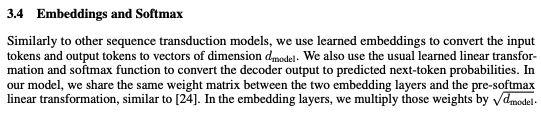  
    <font color=red>Transcription：
    **3.4 Embeddings and Softmax**
    Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension 𝑑model. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [24]. In the embedding layers, we multiply those weights by $\sqrt{𝑑_model}$  
    
    This aspect is not justified by the authors, either on the paper or anywhere else. It was specifically asked as an issue in the original implementation by Google with no response.      
        
    Other implementations of the Transformer have also wondered if this was actually needed (see this, this and this).   
    Some hypothesithed arguments (source) are:   
        
        It is for the sharing weight between the decoder embedding and the decoder pre-softmax linear weights.  
        It is not actually needed.  
        It is to make the positional encoding relatively smaller. This means the original meaning in the embedding vector won’t be lost when we add them together.  
        For reference, there are other StackExchange questions discussing this (see this and this).
    Thank-you!! I'd also missed that multiply in my (fairseq transformer) code study, and it helps clear up a mystery that I'd noted: the (sinusoidal, non-learned) **positional embeddings are initialized with a range of -1.0 to +1.0, but the word-embeddings are initialized with a mean of 0.0 and s.d. of embedding_dim ** -0.5 (0.044 for 512, 0.03125 for 1024).**

    So, on the face of it, the positional embeddings would overwhelm any signal coming from the word embeddings.

    But now I can see word embeddings are scaled by math.sqrt(embed_dim) (22.6 for 512, 32 for 1024), it makes sense again.
    Following the links in the other answer, it seems it is done this way <font color=red>**because the same embeddings can be used in other parts of the transformer model**, and that has decided the initialization values.<\font>

3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
   
   https://discuss.pytorch.org/t/why-use-dropout-in-positional-encoding-layer/159923/6      
   Dropout is a type of regularization. The final embedding for each token that you use (for the transformer) is a sum of positional and standard embeddings and then they apply dropout to that sum. So dropout is applied to the sum of the standard embedding and the positional embedding, not just the (constant) positional embedding. This sum is then an embedding, a bunch of parameters, and dropout is used to regularize as is usual. 
   usually the “embedding” of a word is the embedding that’s used for that token. In this case, <font color=red>**the embedding is the parametric embedding + the constant positional encoding**</font>. When you apply dropout to a neuron, you kill the entire neuron. So if you have a sequence of length 10 and each token has 512 dimensional vectors, you kill on average 60% of the neurons in the 10 by 512 matrix that represents the data. If you only did this to the parametric embeddings and not the positional ones, you would not kill a neuron, you’d leave in its positional information, so it’s not really dropout.

        
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [81]:
1024**(-0.5)

0.03125

In [82]:
 # UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim) #tensorflow Embedding function generate embedding matrix
        self.pos_encoding = positional_encoding(maximum_position_encoding,  #generate the postion encoding matrix
                                                self.embedding_dim)

        #init EncoderLayer 
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
    
        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # why we first have one dropout layer ???
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training, mask)
        # END CODE HERE
        #Embedding layer also include FFN (feed forward network) +  dropout layer + normalize layer
        #the output is (batch_size, input_seq_len, embedding_dim) same as input

        return x  # (batch_size, input_seq_len, embedding_dim)

In [83]:
# UNIT TEST
def Encoder_test(target):
    tf.random.set_seed(10)
    
    embedding_dim=4
    
    encoderq = target(num_layers=2,
                      embedding_dim=embedding_dim,
                      num_heads=2,
                      fully_connected_dim=8,
                      input_vocab_size=32,
                      maximum_position_encoding=5)
    
    x = np.array([[2, 1, 3], [1, 2, 0]])
    
    encoderq_output = encoderq(x, True, None)
    
    assert tf.is_tensor(encoderq_output), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoderq_output).numpy()) == (x.shape[0], x.shape[1], embedding_dim), f"Wrong shape. We expected ({eshape[0]}, {eshape[1]}, {embedding_dim})"
    assert np.allclose(encoderq_output.numpy(), 
                       [[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]]), "Wrong values"
    
    print("\033[92mAll tests passed")
    
Encoder_test(Encoder)

AssertionError: Wrong values

<a name='5'></a>
## 5 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and in computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<center><img src="./assets/decoder_layer.png" alt="Encoder" width="250" class="centerImage"/></center>
<caption><center><font color='purple'>Figure 3a: Transformer Decoder layer</font></center></caption>

<a name='5-1'></a>    
### 5.1 - Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).

<a name='ex-6'></a>    
### Exercise 6 - DecoderLayer (include FFN+dropout+normlize layer)
    
Implement `DecoderLayer()` using the `call()` method
    
1. Block 1 is a multi-head attention layer with a residual connection, dropout layer, and look-ahead mask.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a dropout layer, layer normalization and a residual connection, just like you've done before. 
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
    
**Additional Hints:**
* The first two blocks are fairly similar to the EncoderLayer except you will return `attention_scores` when computing self-attention

In [84]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION DecoderLayer
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        if (ownMultiHead==False):
            self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=embedding_dim)
            self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=embedding_dim)            
        else:
            self.mha1 = MultiHeadAttention(embedding_dim, num_heads) # there are own wq1, wk1, wv1 for multihead 1
            self.mha2 = MultiHeadAttention(embedding_dim, num_heads) # there are own wq2, wk2, wv2 for multihead 2

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1 (~1 line)
        # decode first mh use x as input + look_ahead_mask
        attn1, attn_weights_block1 = self.mha1(x, x, x,look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn1 = self.dropout1(attn1, training = training)
        
        # apply layer normalization to the sum of the attention output and the input (~1 line)
        out1 = self.layernorm1(attn1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.  so , K V is same from the output??
        # MultiHeadAttention's call takes input (Query, Value, Key, attention_mask, return_attention_scores, training)
        # Return attention scores as attn_weights_block2 (~1 line)
        attn2, attn_weights_block2 = self.mha2( out1,enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn2 = self.dropout2(attn2, training=training)
        
        # apply layer normalization to the sum of the attention output and the output of the first block (~1 line)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embedding_dim)
        
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # apply layer normalization to the sum of the ffn output and the output of the second block
        out3 =  self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, embedding_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2
    

In [85]:
# UNIT TEST
ownMultiHead=True
def DecoderLayer_test(target):
    
    num_heads=2  # change to smaller number than embedding_dim
    tf.random.set_seed(10)
    
    decoderLayerq = target(
        embedding_dim=4, 
        num_heads=num_heads,
        fully_connected_dim=32, 
        dropout_rate=0.1, 
        layernorm_eps=1e-6)
    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                                   [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                                   [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]]])
    
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    
    look_ahead_mask = tf.constant([[1., 0., 0.],
                       [1., 1., 0.],
                       [1., 1., 1.]])
    
    padding_mask = None
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)
    
    assert tf.is_tensor(attn_w_b1), "Wrong type for attn_w_b1. Output must be a tensor"
    assert tf.is_tensor(attn_w_b2), "Wrong type for attn_w_b2. Output must be a tensor"
    assert tf.is_tensor(out), "Wrong type for out. Output must be a tensor"
    
    shape1 = (q.shape[0], num_heads, q.shape[1], q.shape[1])
    assert tuple(tf.shape(attn_w_b1).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(attn_w_b2).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(out).numpy()) == q.shape, f"Wrong shape. We expected {q.shape}"

    assert np.allclose(attn_w_b1[0, 0, 1], [0.5271505,  0.47284946, 0.], atol=1e-2), "Wrong values in attn_w_b1. Check the call to self.mha1"
    assert np.allclose(attn_w_b2[0, 0, 1], [0.33365652, 0.32598493, 0.34035856]),  "Wrong values in attn_w_b2. Check the call to self.mha2"
    assert np.allclose(out[0, 0], [0.04726627, -1.6235218, 1.0327158, 0.54353976]), "Wrong values in out"
    

    # Now let's try a example with padding mask
    padding_mask = np.array([[0, 0, 1]])
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)

    assert np.allclose(out[0, 0], [-0.34323323, -1.4689083, 1.1092525, 0.7028891]), "Wrong values in out when we mask the last word. Are you passing the padding_mask to the inner functions?"

    print("\033[92mAll tests passed")
    
DecoderLayer_test(DecoderLayer)

AssertionError: Wrong values in attn_w_b1. Check the call to self.mha1

In [86]:
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [87]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

<a name='5-2'></a> 
### 5.2 - Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embedd your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers. 

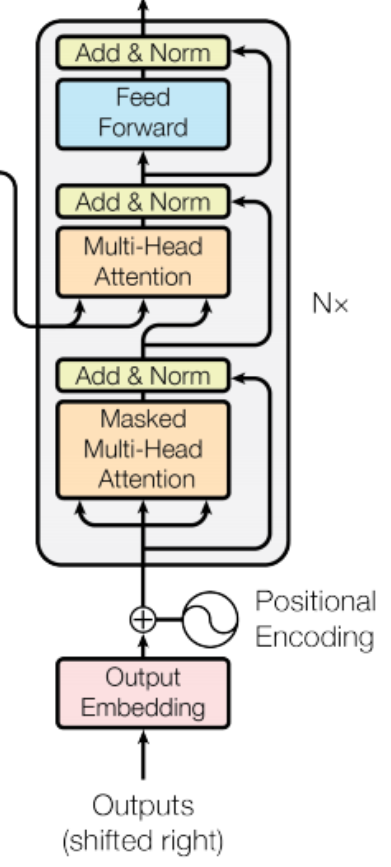
<center><img src="./assets/decoder.png" alt="Encoder" width="300"/></center>
<caption><center><font color='purple'>Figure 3b: Transformer Decoder</b></font></center></caption>

<a name='ex-7'></a>     
### Exercise 7 - Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers
 
In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps: 
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

解码器包括：

- 输出嵌入（Output Embedding）
- 位置编码（Positional Encoding）
- N 个解码器层（decoder layers）
目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [88]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Decoder
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # START CODE HERE
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]
        
        # apply a dropout layer to x
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            #the layer(i) mh2's output will be the layer(i+1)'s input x
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #update/store attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [ ]:
# UNIT TEST
def Decoder_test(target):
    
    tf.random.set_seed(10)
        
    num_layers=7
    embedding_dim=4 
    num_heads=2
    fully_connected_dim=8
    target_vocab_size=33
    maximum_position_encoding=6
    
    x = np.array([[3, 2, 1], [2, 1, 0]])

    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]])
    
    look_ahead_mask = tf.constant([[1., 0., 0.],
                       [1., 1., 0.],
                       [1., 1., 1.]])
    
    decoderk = Decoder(num_layers,
                    embedding_dim, 
                    num_heads, 
                    fully_connected_dim,
                    target_vocab_size,
                    maximum_position_encoding)
    outd, att_weights = decoderk(x, encoderq_output, False, look_ahead_mask, None)
    
    assert tf.is_tensor(outd), "Wrong type for outd. It must be a dict"
    assert np.allclose(tf.shape(outd), tf.shape(encoderq_output)), f"Wrong shape. We expected { tf.shape(encoderq_output)}"
    print(outd[1, 1])
    assert np.allclose(outd[1, 1], [-0.2715261, -0.5606001, -0.861783, 1.69390933]), "Wrong values in outd"
    
    keys = list(att_weights.keys())
    assert type(att_weights) == dict, "Wrong type for att_weights[0]. Output must be a tensor"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(att_weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
    shape1 = (x.shape[0], num_heads, x.shape[1], x.shape[1])
    assert tuple(tf.shape(att_weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(att_weights[keys[0]][0, 0, 1], [0.52145624, 0.47854376, 0.]), f"Wrong values in att_weights[{keys[0]}]"
    
    print("\033[92mAll tests passed")
    
Decoder_test(Decoder)

<a name='6'></a> 
## 6 - Transformer

Phew! This has been quite the assignment, and now you've made it to your last exercise of the Deep Learning Specialization. Congratulations! You've done all the hard work, now it's time to put it all together.  

<center><img src="./assets/transformer.png" alt="Transformer" width="550"/></center>
<caption><center><font color='purple'>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - **the decode input:tar is the target stenece? ---  the encodeing input's shifted right???**
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, two dense layers and a softmax are applied to generate prediction for the next output in your sequence.

<a name='ex-8'></a> 
### Exercise 8 - Transformer

Implement `Transformer()` using the `call()` method
1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [90]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Transformer
# max_positional_encoding_target is used for decoder maximum_position_encoding
# max_positional_encoding_input is used for encoder maximum_position_encoding
# tar as the decoder X
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(inp,training,enc_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        # so the tar is the target stenece? ---  the encodeing input's shifted right???
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        # START CODE HERE

        return final_output, attention_weights

In [91]:
# UNIT TEST
ownMultiHead=False
def Transformer_test(target):
    
    tf.random.set_seed(10)


    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6

    trans = Transformer(num_layers, 
                        embedding_dim, 
                        num_heads, 
                        fully_connected_dim, 
                        input_vocab_size, 
                        target_vocab_size, 
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])

    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    
    
    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
        
    print(translation[0, 0, 0:8])
    assert np.allclose(translation[0, 0, 0:8],
                       [[0.02616475, 0.02074359, 0.01675757, 
                         0.025527, 0.04473696, 0.02171909, 
                         0.01542725, 0.03658631]]), "Wrong values in outd"
    
    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"

    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"
    
    print(translation)
    
    print("\033[92mAll tests passed")

    
Transformer_test(Transformer)


tf.Tensor(
[0.02616475 0.02074359 0.01675757 0.025527   0.04473695 0.02171909
 0.01542725 0.0365863 ], shape=(8,), dtype=float32)
tf.Tensor(
[[[0.02616475 0.02074359 0.01675757 0.025527   0.04473695 0.02171909
   0.01542725 0.0365863  0.02433536 0.02948791 0.01698964 0.02147779
   0.05749574 0.02669398 0.01277918 0.03276358 0.0253941  0.01698772
   0.02758246 0.02529753 0.04394253 0.06258808 0.03667333 0.03009711
   0.05011231 0.01414333 0.01601289 0.01800467 0.02506283 0.01607273
   0.06204056 0.02099288 0.03005534 0.03070701 0.01854689]
  [0.02490053 0.017258   0.01794803 0.02998916 0.05038005 0.01997477
   0.01526351 0.03385608 0.03138068 0.02608407 0.01852771 0.01744511
   0.05923333 0.03287778 0.01450072 0.02815487 0.02676623 0.01684978
   0.02482791 0.02307897 0.04122656 0.05552058 0.03742857 0.03390088
   0.04666695 0.01667501 0.01400229 0.01981527 0.02202851 0.01818
   0.05918451 0.02173372 0.03040997 0.03337187 0.02055808]
  [0.01867789 0.01225462 0.02509719 0.04180384 0.06244

In [49]:
# UNIT TEST
ownMultiHead=True
def Transformer_test(target):
    
    tf.random.set_seed(10)


    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6

    trans = Transformer(num_layers, 
                        embedding_dim, 
                        num_heads, 
                        fully_connected_dim, 
                        input_vocab_size, 
                        target_vocab_size, 
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])

    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    
    
    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
        
    print(translation[0, 0, 0:8])
    
    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"

    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    #assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"
    
    print(translation)
    
    print("\033[92mAll tests passed")
Transformer_test(Transformer)    

tf.Tensor(
[0.0138899  0.03013041 0.0194122  0.02183245 0.0163418  0.03393482
 0.05421878 0.04387819], shape=(8,), dtype=float32)
tf.Tensor(
[[[0.0138899  0.03013041 0.0194122  0.02183245 0.0163418  0.03393482
   0.05421878 0.04387819 0.0329827  0.01397073 0.03924095 0.01440488
   0.03002763 0.0154879  0.0176722  0.01628551 0.01585947 0.01415133
   0.03792994 0.02771122 0.02725577 0.02476936 0.04830182 0.07570544
   0.02002317 0.02237192 0.02127243 0.02123942 0.01698944 0.02112064
   0.043529   0.03428836 0.04166754 0.04055457 0.03154815]
  [0.01227451 0.02959899 0.0166487  0.02353616 0.01820176 0.03310344
   0.05079214 0.05486127 0.03501931 0.01502464 0.03344036 0.01418775
   0.03232233 0.01766093 0.01824826 0.01715104 0.01604581 0.01408619
   0.04389434 0.02434369 0.03227949 0.02387203 0.03963812 0.07077137
   0.01703417 0.01782698 0.02154371 0.02032982 0.01434441 0.02211295
   0.05294901 0.03850862 0.03668781 0.04071193 0.03094796]
  [0.01763018 0.03471405 0.01863351 0.02474838 0.02

In [92]:
ownMultiHead=True
sample_transformer = Transformer(
    num_layers=2, embedding_dim=512, num_heads=8, fully_connected_dim=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    max_positional_encoding_input=10000, 
    max_positional_encoding_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

配置超参数（hyperparameters）
为了让本示例小且相对较快，已经减小了num_layers、 d_model 和 dff 的值。

Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048。关于所有其他版本的 Transformer，请查阅论文。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [95]:
import tensorflow_datasets as tfds
import time

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/124 [00:00<?, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   1%|          | 1/124 [00:00<01:27,  1.41 MiB/s]

Dl Size...:   2%|▏         | 2/124 [00:00<01:26,  1.41 MiB/s]

Dl Size...:   2%|▏         | 3/124 [00:00<01:25,  1.41 MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   3%|▎         | 4/124 [00:00<00:20,  5.82 MiB/s]

Dl Size...:   4%|▍         | 5/124 [00:00<00:20,  5.82 MiB/s]

Dl Size...:   5%|▍         | 6/124 [00:00<00:20,  5.82 MiB/s]

Dl Size...:   6%|▌         | 7/124 [00:00<00:20,  5.82 MiB/s]

Dl Size...:   6%|▋         | 8/124 [00:00<00:19,  5.82 MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   7%|▋         | 9/124 [00:00<00:08, 13.05 MiB/s]

Dl Size...:   8%|▊         | 10/124 [00:01<00:08, 13.05 MiB

Shuffling...:   0%|          | 0/1 [00:00<?, ? shard/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Reading...: 0 examples [00:00, ? examples/s]
                                            
Shuffling...:   0%|          | 0/1 [00:00<?, ? shard/s]        
Reading...: 0 examples [00:00, ? examples/s]
                                            
Shuffling...:   0%|          | 0/1 [00:00<?, ? shard/s]    
Reading...: 0 examples [00:00, ? examples/s]
                                            
Writing...:   0%|          | 0/1803 [00:00<?, ? examples/s]


Dataset ted_hrlr_translate downloaded and prepared to /home/jupyter/tensorflow_datasets/ted_hrlr_translate/pt_to_en/0.0.1. Subsequent calls will reuse this data.


In [96]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

2023-05-09 11:56:13.233103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [98]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [99]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [100]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [101]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

In [103]:
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    
    return result_pt, result_en

In [104]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [105]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

In [106]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

优化器（Optimizer）
根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [109]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

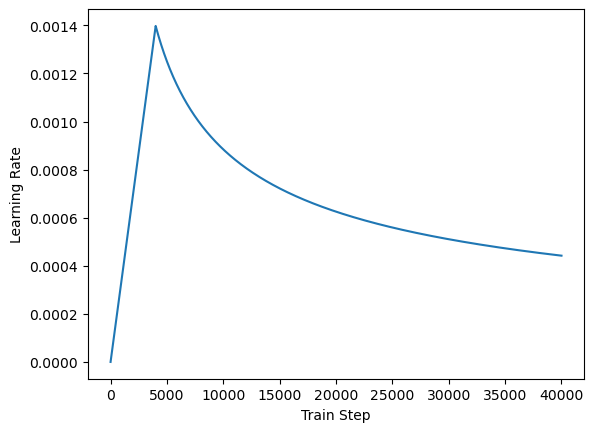

In [110]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [111]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [112]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [116]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          max_positional_encoding_input=input_vocab_size, 
                          max_positional_encoding_target=target_vocab_size,
                          dropout_rate=dropout_rate)
    
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)
    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [117]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [118]:
EPOCHS = 20
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        
        gradients = tape.gradient(loss, transformer.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(tar_real, predictions)

In [119]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                            train_loss.result(), 
                                            train_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

2023-05-09 12:09:35.813744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13805 of 20000
2023-05-09 12:09:40.167687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
/opt/conda/envs/tf/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1 Batch 0 Loss 4.4735 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2140 Accuracy 0.0030
Epoch 1 Batch 100 Loss 4.1867 Accuracy 0.0151
Epoch 1 Batch 150 Loss 4.1394 Accuracy 0.0195
Epoch 1 Batch 200 Loss 4.0686 Accuracy 0.0261
Epoch 1 Batch 250 Loss 3.9926 Accuracy 0.0342
Epoch 1 Batch 300 Loss 3.9032 Accuracy 0.0396
Epoch 1 Batch 350 Loss 3.8193 Accuracy 0.0438
Epoch 1 Batch 400 Loss 3.7331 Accuracy 0.0472
Epoch 1 Batch 450 Loss 3.6467 Accuracy 0.0520
Epoch 1 Batch 500 Loss 3.5620 Accuracy 0.0580
Epoch 1 Batch 550 Loss 3.4791 Accuracy 0.0647
Epoch 1 Batch 600 Loss 3.3928 Accuracy 0.0722
Epoch 1 Batch 650 Loss 3.3050 Accuracy 0.0804
Epoch 1 Batch 700 Loss 3.2147 Accuracy 0.0884
Epoch 1 Loss 3.2126 Accuracy 0.0887
Time taken for 1 epoch: 931.3518960475922 secs

Epoch 2 Batch 0 Loss 2.1738 Accuracy 0.2027
Epoch 2 Batch 50 Loss 1.8804 Accuracy 0.2144
Epoch 2 Batch 100 Loss 1.8061 Accuracy 0.2266
Epoch 2 Batch 150 Loss 1.7319 Accuracy 0.2366
Epoch 2 Batch 200 Loss 1.6622 Accuracy 0.2467
Ep

## Conclusion

You've come to the end of the graded portion of the assignment. By now, you've: 

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

<b>What you should remember</b>:

- The combination of self-attention and convolutional network layers allows of parallization of training and *faster training*.
- Self-attention is calculated using the generated query Q, key K, and value V matrices.
- Adding positional encoding to word embeddings is an effective way of include sequence information in self-attention calculations. 
- Multi-head attention can help detect multiple features in your sentence.
- Masking stops the model from 'looking ahead' during training, or weighting zeroes too much when processing cropped sentences.

Now that you have completed the Transformer assignment, make sure you check out the ungraded labs to apply the Transformer model to practical use cases such as Name Entity Recogntion (NER) and Question Answering (QA).  


# Congratulations on finishing the Deep Learning Specialization!!!!!! 🎉

This was the last graded assignment of the specialization. It is now time to celebrate all your hard work and dedication! 

<a name='7'></a> 
## 7 - References

The Transformer algorithm was due to Vaswani et al. (2017). 

- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 

**Training**
This section describes the training regime for our models.

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [ ]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)